In [40]:
import os
import time
import random
import sys  
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "../"))
if ROOT_DIR not in sys.path:
    sys.path.insert(0, ROOT_DIR)
print(ROOT_DIR)

from src.utils.pil import base64_to_pil

/root/upstageailab-cv-classification-cv_7


# MissClassification 분석


In [3]:
data_path = "./../../data/misclassification.csv"
df = pd.read_csv(data_path)

df.head()

fold              img_name  pred  label  \
0     0  0134204c33c8d37c.jpg     5      5   
1     0  01af3d4c58c8530f.jpg    15     15   
2     0  024fe478044874ab.jpg     3     13   
3     0  02533d35fe935981.jpg    11     11   
4     0  03648b6855b9f8c1.jpg    10     10   

                                                 img  
0  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
1  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
2  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
3  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...  
4  iVBORw0KGgoAAAANSUhEUgAAAMAAAADACAIAAADdvvtQAA...

In [41]:
# classification_report 로 f1 score 계산
report = classification_report(df['label'], df['pred'], output_dict=True)
report_df = pd.DataFrame(report).transpose().reset_index()
report_df = report_df.rename(columns={"index": "class"})

# 정수 클래스만 필터링 (macro avg, weighted avg 제외)
report_df = report_df[report_df['class'].str.isdigit()]
report_df['class'] = report_df['class'].astype(int)

report_df = report_df.sort_values(by='class').reset_index(drop=True)

In [42]:
display(report_df)

class  precision    recall  f1-score  support
0       0   0.990099  1.000000  0.995025    200.0
1       1   0.946809  0.967391  0.956989     92.0
2       2   1.000000  1.000000  1.000000    200.0
3       3   0.573394  0.625000  0.598086    200.0
4       4   0.876923  0.855000  0.865823    200.0
5       5   1.000000  1.000000  1.000000    200.0
6       6   0.995000  0.995000  0.995000    200.0
7       7   0.572864  0.570000  0.571429    200.0
8       8   1.000000  0.995000  0.997494    200.0
9       9   1.000000  1.000000  1.000000    200.0
10     10   0.963542  0.925000  0.943878    200.0
11     11   0.954774  0.950000  0.952381    200.0
12     12   0.970297  0.980000  0.975124    200.0
13     13   0.952381  0.945946  0.949153    148.0
14     14   0.755556  0.680000  0.715789    100.0
15     15   0.985222  1.000000  0.992556    200.0
16     16   1.000000  1.000000  1.000000    200.0

In [4]:
mapping_df = pd.read_csv("./../../data/meta.csv")

## 틀린 이미지 분석

In [5]:
df_miss = df[df["pred"] != df["label"]]

# 데이터 분포 확인
display(df_miss["label"].value_counts())

# 데이터 분포 확인
display(df_miss["pred"].value_counts())

# 데이터 분포 확인
display(df_miss["fold"].value_counts())

# 데이터 분포 확인

label
7     86
3     75
14    32
4     29
10    15
11    10
13     8
12     4
1      3
8      1
6      1
Name: count, dtype: int64

pred
3     93
7     85
4     24
14    22
11     9
10     7
13     7
12     6
1      5
15     3
0      2
6      1
Name: count, dtype: int64

fold
4    64
0    60
3    49
1    47
2    44
Name: count, dtype: int64

In [ ]:
def show_images_with_preds(base64_list, preds, labels, n_cols=4):
    n_imgs = len(base64_list)
    n_rows = (n_imgs + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    for i, base64_str in enumerate(base64_list):
        img = base64_to_pil(base64_str)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        pred = preds[i]
        label = labels[i]
        title = f"Pred: {pred} | Label: {label}"
        color = "green" if pred == label else "red"
        plt.title(title, color=color)

    plt.tight_layout()
    plt.show()

### label = 3(confirmation_of_admission_and_discharge) 분석

In [7]:
df_miss3 = df_miss[df_miss['label'] == 3]

df_miss3['pred'].value_counts()

pred
7     56
4      9
14     6
1      1
12     1
11     1
10     1
Name: count, dtype: int64

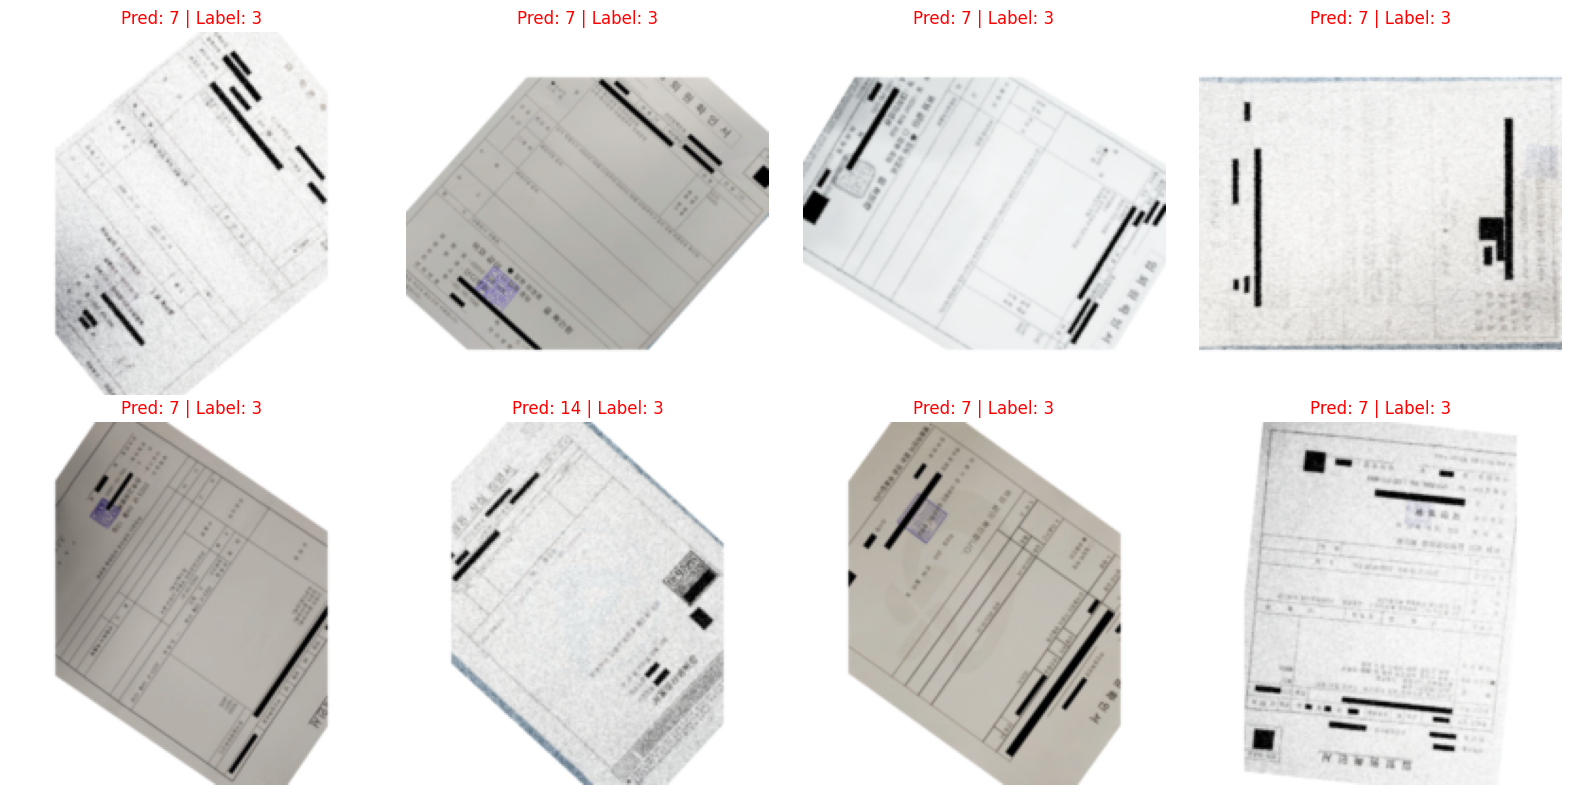

In [68]:
# 예시: DataFrame에서 8개만 시각화
df_subset = df_miss3.iloc[np.random.choice(len(df_miss3), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)


### label=7(medical_outpatient_certificate) 분석


In [ ]:
df_miss7 = df_miss[df_miss['label'] == 7]

df_miss7['pred'].value_counts()


pred
3     70
14     7
4      5
13     3
12     1
Name: count, dtype: int64

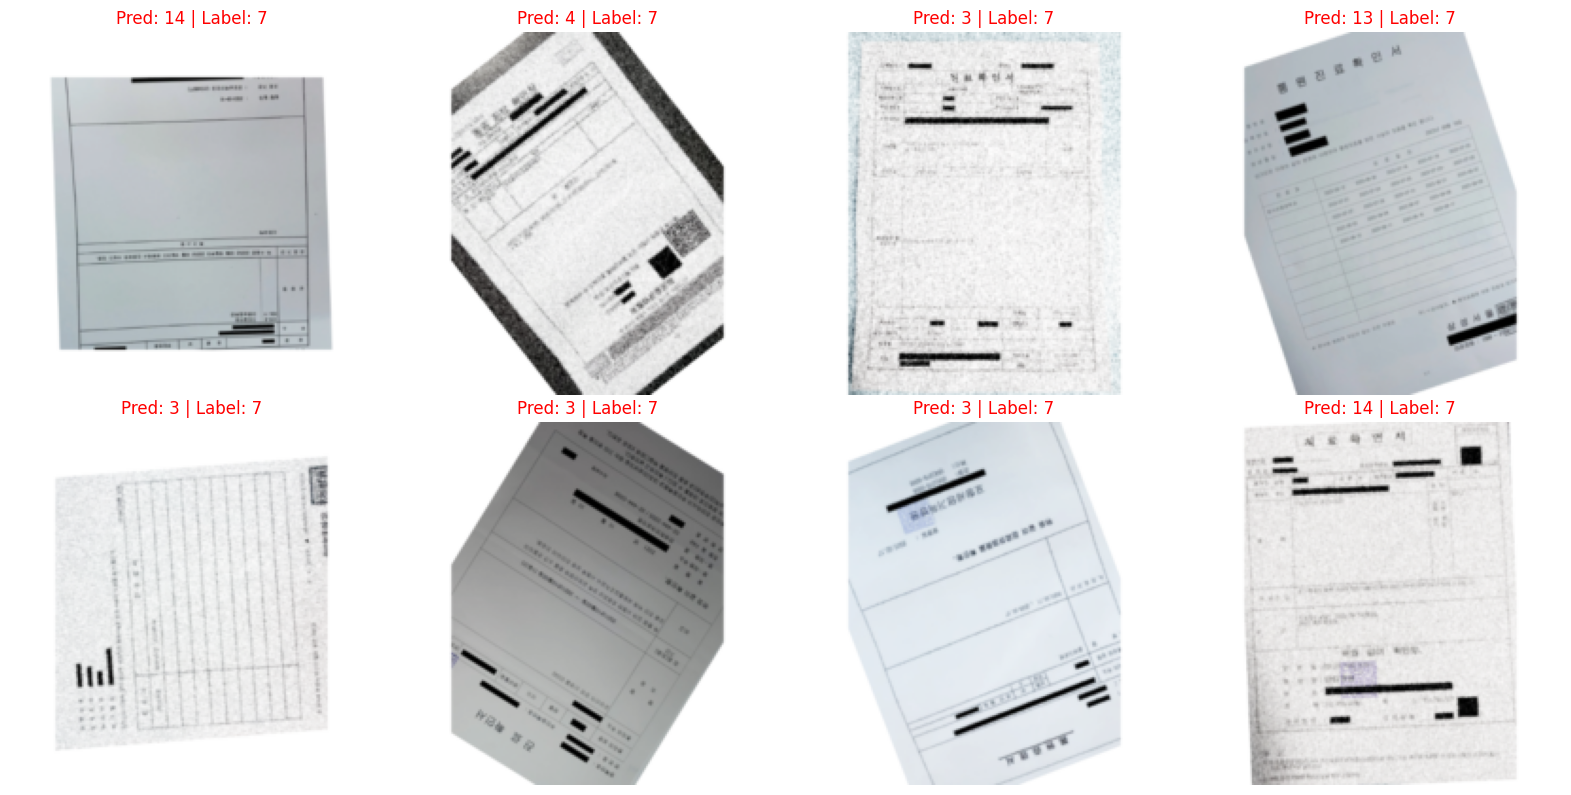

In [66]:
df_subset = df_miss7.iloc[np.random.choice(len(df_miss7), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)

### label = 14(statement_of_opinion) 분석


In [28]:
df_miss14 = df_miss[df_miss['label'] == 14]

df_miss14['pred'].value_counts()

pred
7     13
3     10
4      7
11     2
Name: count, dtype: int64

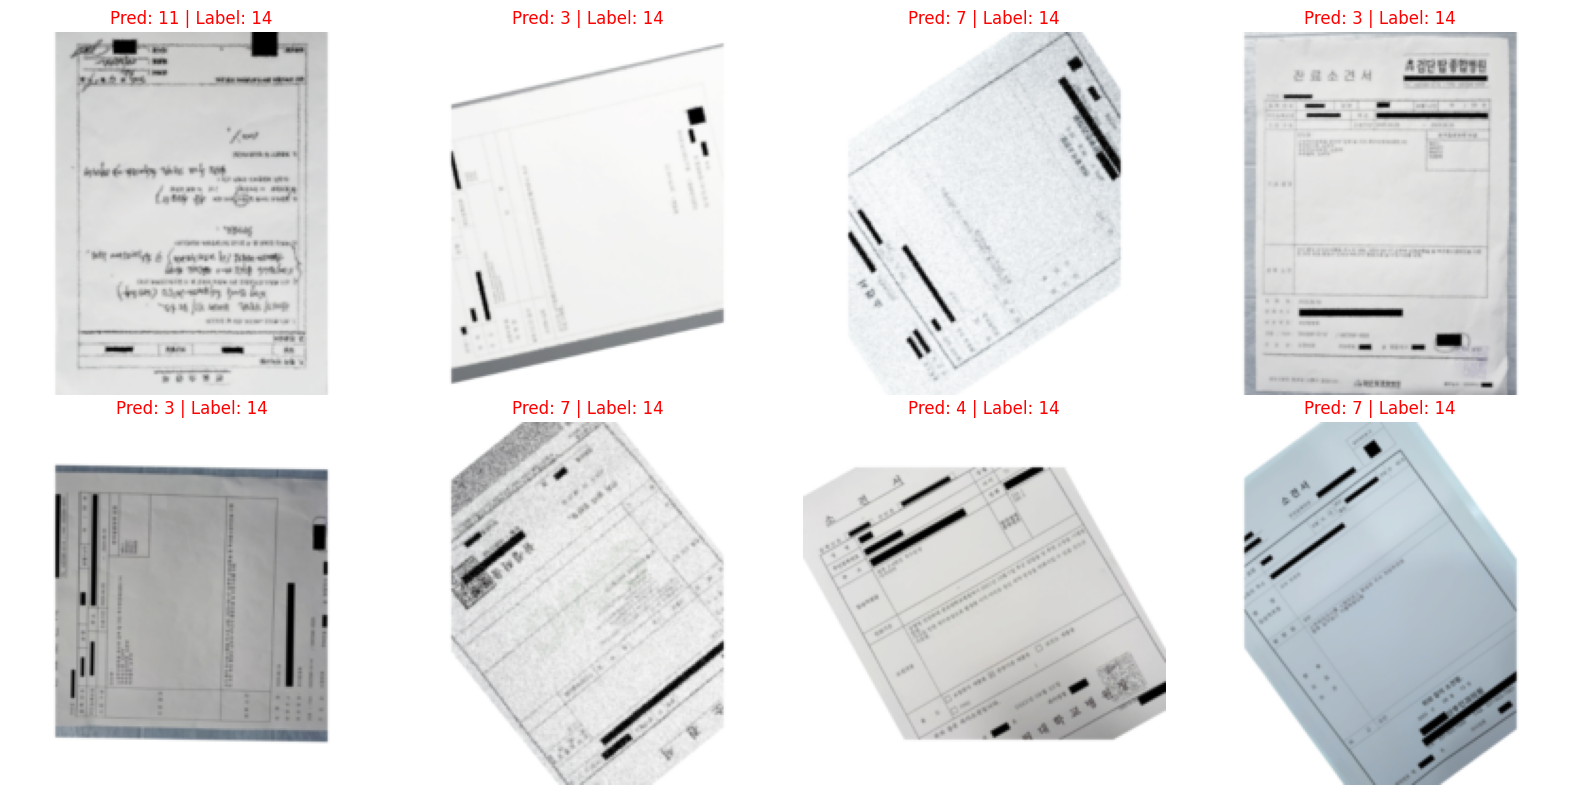

In [32]:
df_subset = df_miss14.iloc[np.random.choice(len(df_miss14), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)

### 맞춘 데이터 확인

In [33]:
df_correct = df[df['pred'] == df['label']]

df_correct['pred'].value_counts()

pred
5     200
9     200
2     200
15    200
0     200
16    200
8     199
6     199
12    196
11    190
10    185
4     171
13    140
3     125
7     114
1      89
14     68
Name: count, dtype: int64

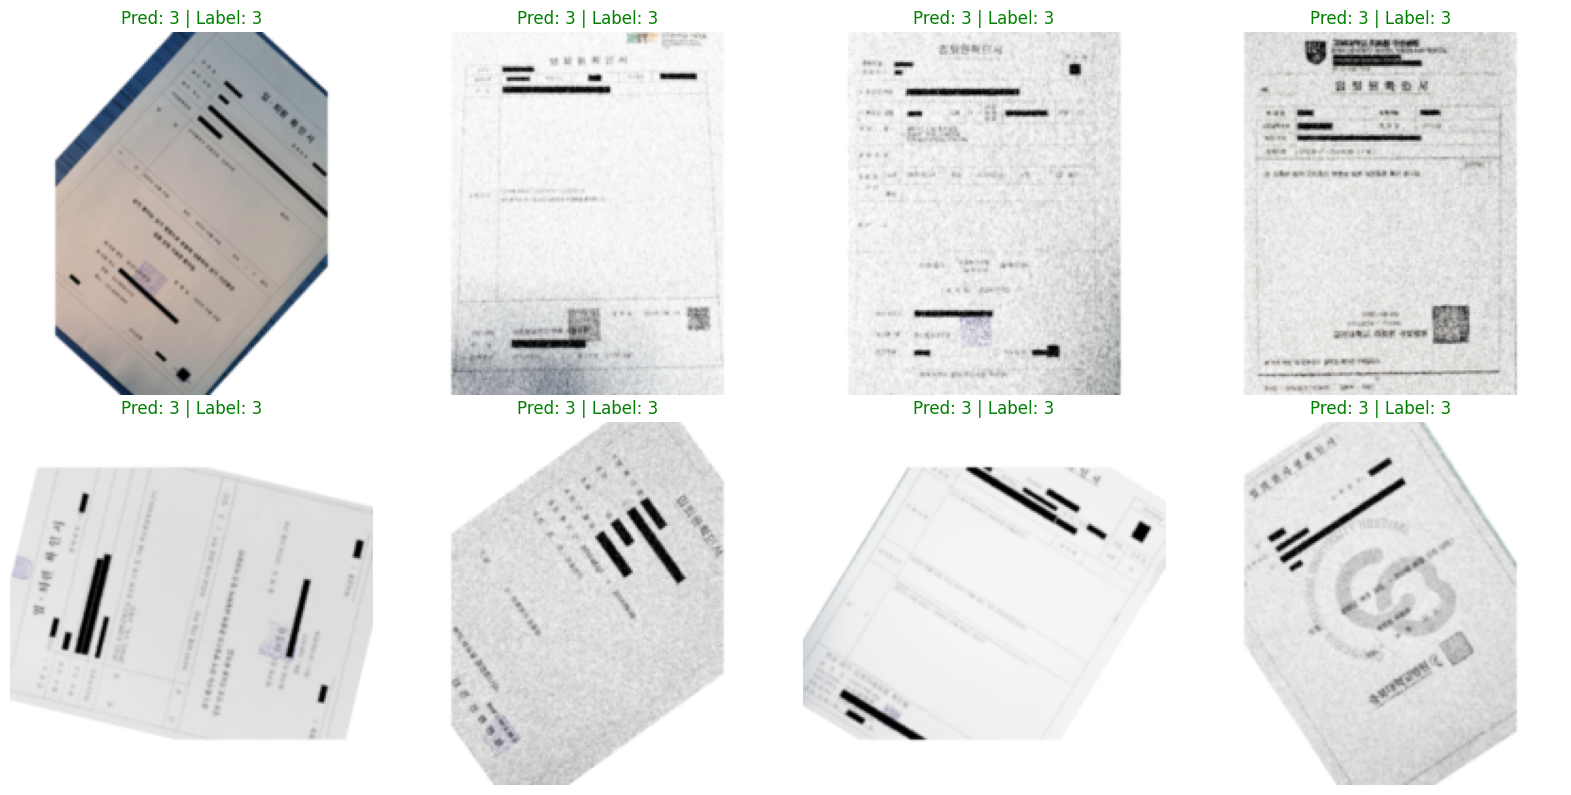

In [52]:
df_correct3 = df_correct[df_correct['label'] == 3]

df_subset = df_correct3.iloc[np.random.choice(len(df_correct3), size=8, replace=False)]

base64_list = df_subset["img"].tolist()
preds = df_subset["pred"].tolist()
labels = df_subset["label"].tolist()

show_images_with_preds(base64_list, preds, labels)